In [1]:

import numpy
import sklearn.metrics
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
# Load packages
import json

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from sklearn.neighbors import NearestNeighbors

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Modèles de ML

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet

color = sns.color_palette()

from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import pickle


In [3]:
import matplotlib.pyplot as plt

In [4]:
import requests
from functionsp7 import*
from functions_API import*
import dill

In [5]:
def chargement_data():
    path_data_test = r'C:\Users\simon\OneDrive\Bureau\CODE\P7_OC\data_test_preprocessed.csv'
    path_model =  r'C:\Users\simon\OneDrive\Bureau\CODE\P7_OC\modele_LR_precise'
    data_test = pd.read_csv(path_data_test)
    model = pickle.load(open(path_model, 'rb'))
    return data_test,model

path_explainer = r'C:\Users\simon\OneDrive\Bureau\CODE\P7_OC\explainer_file'

def get_prediction_and_explaination(data, client_id, model_local, explainer):
    try:
        index_client = data[data["SK_ID_CURR"] == client_id].index[0]
    except:
        return "This client ID does not exist"

    data_no_id = data.drop(["SK_ID_CURR"], axis=1)

    data_client = data[data["SK_ID_CURR"] == client_id]

    data_client = data_client.drop(["SK_ID_CURR"], axis=1)

    y_pred_proba = model_local.predict_proba(data_client)

    # proba_remboursement = y_pred_proba[0,1]
    proba_remboursement = y_pred_proba

    class_target = int(proba_to_class(y_pred_proba, threshold=0.8))

    local_explaination = explainer.explain_instance(data_client.squeeze(), model_local.predict_proba,
                                                    num_features=10)
    local_explaination_list = local_explaination.as_list()
    local_explaination_map = local_explaination.as_map()

    feature_values=[]
    feature_names=[]

    for feat in local_explaination_map[1]:
        index_feature = feat[0]
        feature_values.append(data_client.iloc[:,index_feature].item())
        feature_name = data_client.columns.to_list()[index_feature]
        feature_names.append(feature_name)


    return proba_remboursement.tolist(), class_target, local_explaination_list, feature_values, feature_names





def get_graphs(list_expl, feature_values,feature_names , means_global, means_repay, means_default):

    fig, axes = plt.subplots(2,3)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    types = ["Client","Moyenne", "En Règle", "En Défaut"]



    for i in range(len(list_expl)):

        value = feature_values[i]
        title = feature_names[i]

        participation = list_expl[i][1]

        if i>5:
            break
        if i<3:
            ax = axes[0,i]
        else :
            ax = axes[1,i-3]



        if participation <= 0 :
            title = title + "\n (Améliore le score)"
            ax.title.set_text(title)
            fontdict = {"color" : "green"}
        else:
            title = title + "\n (Dégrade le score)"
            ax.title.set_text(title)
            fontdict = {"color" : "red"}

        value_mean_global = means_global[title]
        value_mean_repay = means_repay[title]
        value_mean_default = means_default[title]

        ax.bar(types,[value, value_mean_global, value_mean_repay, value_mean_default])

    return fig, axes


with open(path_explainer, 'rb') as f:
    explainer = dill.load(f)




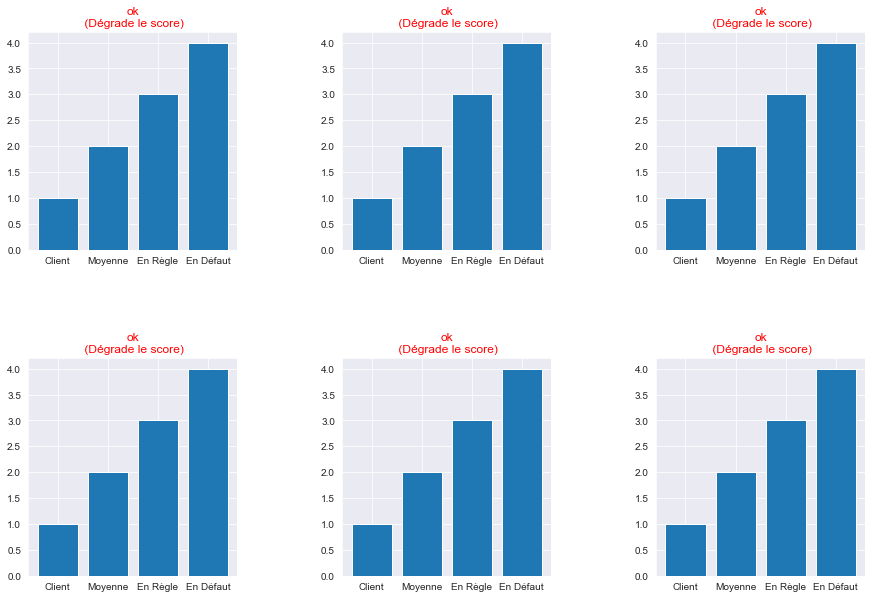

In [44]:
fig, axes = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)
types = ["Client","Moyenne", "En Règle", "En Défaut"]
for i in range(6):
    if i>5:
        break
    if i<3:
        ax = axes[0,i]
    else :
        ax = axes[1,i-3]
    title = "ok"
    title = title + "\n (Dégrade le score)"

    fontdict = {"color" : "red"}

    ax.set_title(title, fontdict=fontdict)
    ax.bar(types, [1,2,3,4])

    plt.subplots_adjust(wspace=0.5,
                        hspace=0.5)

plt.show()


In [52]:
path_data_global_feat = r'C:\Users\simon\OneDrive\Bureau\CODE\P7_OC\global_feature_importance_sorted.csv'
model = pickle.load(open(r'C:\Users\simon\OneDrive\Bureau\CODE\P7_OC\modele_LR_precise', 'rb'))
data_test_no_id = data_test.drop(["SK_ID_CURR"], axis = 1)

global_feat_importance = get_feature_importance(pipe_model = model, list_features= data_test_no_id.columns.to_list())
global_feat_importance_sorted = global_feat_importance.iloc[0].reindex(global_feat_importance.iloc[0].abs().sort_values(ascending=False).index)

global_feat_importance_sorted = global_feat_importance_sorted.to_frame()

global_feat_importance_sorted["feature"] = global_feat_importance_sorted.index

global_feat_importance_sorted

# global_feat_importance_sorted.to_csv("global_feature_importance_sorted_bis.csv", index=False)

,0,feature
REGION_RATING_CLIENT,4.805867e-01,REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY,4.697936e-01,REGION_RATING_CLIENT_W_CITY
FLAG_OWN_CAR,-4.131190e-01,FLAG_OWN_CAR
OCCUPATION_TYPE_Sales staff,3.904900e-01,OCCUPATION_TYPE_Sales staff
NAME_CONTRACT_TYPE,-3.633924e-01,NAME_CONTRACT_TYPE
...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,2.141052e-05,AMT_REQ_CREDIT_BUREAU_DAY
FLAG_DOCUMENT_12,-1.981216e-05,FLAG_DOCUMENT_12
FLAG_DOCUMENT_10,-9.624048e-06,FLAG_DOCUMENT_10
NAME_TYPE_SUITE_Other_A,-4.555568e-07,NAME_TYPE_SUITE_Other_A


In [53]:
type(global_feat_importance_sorted)

pandas.core.frame.DataFrame

In [1]:
import pandas as pd
test = pd.read_csv("global_feature_importance_sorted_bis.csv")
test

FileNotFoundError: [Errno 2] No such file or directory: 'global_feature_importance_sorted_bis.csv'

In [37]:
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100001,0.0,0.0,1.0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,100005,0.0,0.0,1.0,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0.0,1.0,1.0,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0.0,0.0,1.0,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,100038,0.0,1.0,0.0,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0.0,0.0,1.0,0.000000,0.000819,0.091775,0.061846,0.057239,0.024260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,0.0,0.0,0.0,0.105263,0.001127,0.144173,0.118147,0.113356,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,0.0,1.0,1.0,0.052632,0.001512,0.067416,0.123201,0.068462,0.361433,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
48742,456224,0.0,0.0,0.0,0.000000,0.001704,0.101124,0.091699,0.102132,0.257000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [7]:
data_test[data_test["SK_ID_CURR"]==100005].iloc[:,10].item()

NameError: name 'data_test' is not defined

In [36]:
y_test = data_test
y_test = y_test.drop(["SK_ID_CURR"], axis = 1)

model.predict_proba(y_test)

array([[0.7269083 , 0.2730917 ],
       [0.35982188, 0.64017812],
       [0.7598624 , 0.2401376 ],
       ...,
       [0.72836225, 0.27163775],
       [0.79113589, 0.20886411],
       [0.6713389 , 0.3286611 ]])

In [6]:
data_test,model = chargement_data()

In [8]:
data_test.shape

(48744, 240)

In [16]:
retour = get_prediction_and_explaination(data_test, 100005, model, explainer)


retour



C:\Users\simon\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


([[0.35982188366292234, 0.6401781163370777]],
 1,
 [('OCCUPATION_TYPE_Sales staff <= 0.00', -0.08259864379481052),
  ('FLAG_OWN_CAR <= 0.00', 0.07684823545298655),
  ('ORGANIZATION_TYPE_Business Entity Type 3 <= 0.00', -0.07120932506808701),
  ('NAME_CONTRACT_TYPE <= 0.00', 0.06610457706599504),
  ('REGION_RATING_CLIENT <= 0.50', -0.0633225746313851),
  ('REGION_RATING_CLIENT_W_CITY <= 0.50', -0.06001543610812274),
  ('0.00 < FLAG_DOCUMENT_3 <= 1.00', 0.05438200219020834),
  ('REG_CITY_NOT_LIVE_CITY <= 0.00', -0.05364100952439456),
  ('CODE_GENDER_F <= 0.00', 0.0525028771598583),
  ('0.00 < CODE_GENDER_M <= 1.00', 0.05085631148709979)],
 [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0],
 ['OCCUPATION_TYPE_Sales staff',
  'FLAG_OWN_CAR',
  'ORGANIZATION_TYPE_Business Entity Type 3',
  'NAME_CONTRACT_TYPE',
  'REGION_RATING_CLIENT',
  'REGION_RATING_CLIENT_W_CITY',
  'FLAG_DOCUMENT_3',
  'REG_CITY_NOT_LIVE_CITY',
  'CODE_GENDER_F',
  'CODE_GENDER_M'])

In [268]:
get_graphs(list_expl, feature_values,feature_names , means_global, means_repay, means_default)

153
1
21
169
0
22
82
107
108
27


In [47]:
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100001,0.0,0.0,1.0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,100005,0.0,0.0,1.0,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0.0,1.0,1.0,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0.0,0.0,1.0,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,100038,0.0,1.0,0.0,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0.0,0.0,1.0,0.000000,0.000819,0.091775,0.061846,0.057239,0.024260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,0.0,0.0,0.0,0.105263,0.001127,0.144173,0.118147,0.113356,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,0.0,1.0,1.0,0.052632,0.001512,0.067416,0.123201,0.068462,0.361433,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
48742,456224,0.0,0.0,0.0,0.000000,0.001704,0.101124,0.091699,0.102132,0.257000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [54]:
data_test["SK_ID_CURR"].to_frame().to_csv("valid_IDs_bis.csv", index = False)

In [55]:
data_test["SK_ID_CURR"].to_frame()

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038
...,...
48739,456221
48740,456222
48741,456223
48742,456224


In [64]:
API_url_client = "http://127.0.0.1:8000/get_valid_IDs"
test2 = json.loads(requests.get(API_url_client).text)
test2

'{"SK_ID_CURR":{"0":100001,"1":100005,"2":100013,"3":100028,"4":100038,"5":100042,"6":100057,"7":100065,"8":100066,"9":100067,"10":100074,"11":100090,"12":100091,"13":100092,"14":100106,"15":100107,"16":100109,"17":100117,"18":100128,"19":100141,"20":100150,"21":100168,"22":100169,"23":100170,"24":100171,"25":100172,"26":100184,"27":100187,"28":100212,"29":100222,"30":100223,"31":100232,"32":100241,"33":100245,"34":100253,"35":100256,"36":100271,"37":100278,"38":100280,"39":100306,"40":100311,"41":100312,"42":100330,"43":100331,"44":100352,"45":100358,"46":100367,"47":100382,"48":100384,"49":100385,"50":100386,"51":100399,"52":100404,"53":100416,"54":100422,"55":100426,"56":100438,"57":100444,"58":100445,"59":100446,"60":100447,"61":100450,"62":100466,"63":100483,"64":100484,"65":100494,"66":100510,"67":100512,"68":100517,"69":100548,"70":100551,"71":100552,"72":100553,"73":100561,"74":100568,"75":100569,"76":100591,"77":100592,"78":100602,"79":100607,"80":100613,"81":100617,"82":10061

In [75]:
import ast
test3 = ast.literal_eval(test2)
"lol"  in test3["SK_ID_CURR"].values()

False

In [51]:
test = pd.read_csv("valid_IDs.csv")
type(data_test["SK_ID_CURR"])

pandas.core.series.Series

In [11]:
API_url_client = "http://127.0.0.1:8000/get_global_feat_imp"

In [14]:
testglobal = json.loads(requests.get(API_url_client).text)
testglobal

{'0': {'0': 0.4805866625034837,
  '1': 0.4697936154260704,
  '2': -0.4131189900317356,
  '3': 0.3904900031268459,
  '4': -0.3633924487049185,
  '5': 0.3517224645846018,
  '6': -0.3180482608222582,
  '7': 0.3038149125474731,
  '8': 0.2592106728901335,
  '9': 0.2569225522777658,
  '10': -0.2568632347695315,
  '11': -0.2464128457393386,
  '12': 0.2446256507605568,
  '13': -0.2424360211174503,
  '14': -0.236587074370251,
  '15': 0.217849952213811,
  '16': 0.1805122102864136,
  '17': 0.1731332169885795,
  '18': -0.1677454054937873,
  '19': 0.1665831861483245,
  '20': -0.1514891678686134,
  '21': -0.1332139516476511,
  '22': 0.1331186969204454,
  '23': -0.1321049045773445,
  '24': 0.1236563342005148,
  '25': 0.1216249736855752,
  '26': 0.1205130318616448,
  '27': -0.1195544957558352,
  '28': -0.1129094992648579,
  '29': -0.105515297764341,
  '30': -0.1046343384463003,
  '31': -0.1014481759168199,
  '32': -0.1003868037001926,
  '33': -0.1000759756433926,
  '34': 0.0853510342439071,
  '35': -0

In [19]:
i=2
testglobal["feature"][f"{i}"]

'FLAG_OWN_CAR'

In [20]:
[testglobal["feature"][f"{i}"] for i in range(6)]

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_OWN_CAR',
 'OCCUPATION_TYPE_Sales staff',
 'NAME_CONTRACT_TYPE',
 'ORGANIZATION_TYPE_Business Entity Type 3']

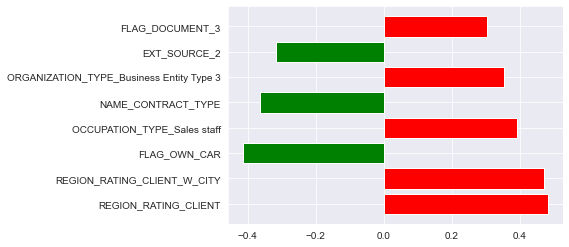

In [37]:
fig,ax= plt.subplots()
color = ["red", "green", "red", "green", "red", "green", "red", "red"]
color = ["red", "red", "green", "red", "green", "red", "green", "red"]
list_most_imp_features = [testglobal["feature"][f"{i}"] for i in range(8)]
list_values = [testglobal["0"][f"{i}"] for i in range(8)]
ax.barh(np.arange(len(list_values)), width= list_values, align='center', tick_label = list_most_imp_features, color= color)
plt.show()

In [223]:
predict_explain = json.loads(requests.get(API_url_client).text)
predict_explain[2]

[['OCCUPATION_TYPE_Sales staff <= 0.00', -0.08256512534522832],
 ['0.00 < FLAG_OWN_CAR <= 1.00', -0.07668779534865343],
 ['ORGANIZATION_TYPE_Business Entity Type 3 <= 0.00', -0.07128871579996042],
 ['NAME_CONTRACT_TYPE <= 0.00', 0.06599055223255869],
 ['REGION_RATING_CLIENT > 0.50', 0.06363591847942725],
 ['REGION_RATING_CLIENT_W_CITY > 0.50', 0.06027937800106988],
 ['0.00 < FLAG_DOCUMENT_3 <= 1.00', 0.05429443508549024],
 ['REG_CITY_NOT_LIVE_CITY <= 0.00', -0.05374119895968802],
 ['CODE_GENDER_F <= 0.00', 0.052363001627499496],
 ['0.00 < CODE_GENDER_M <= 1.00', 0.05075496949781343]]

In [238]:
data_test[data_test["SK_ID_CURR"]==100005]["FLAG_OWN_CAR"]

1    0.0
Name: FLAG_OWN_CAR, dtype: float64

In [250]:
a_dict = {'color': 'blue', 'fruit': 'apple', 'pet': 'dog'}
for element in a_dict:
    print(a_dict[element])

blue
apple
dog


In [236]:
import re
listtest = predict_explain[2][0][0]
res = re.sub(r'[^a-zA-Z_ ]', '', listtest).strip()

print(res)
print(len(res))

res == 'OCCUPATION_TYPE_Sales staff'

OCCUPATION_TYPE_Sales staff
27


True

In [210]:
proba_remboursement = predict_explain[0][0][0]
classe_predite = predict_explain[1]
if classe_predite==1:
    etat = 'client à risque'

else:
    etat = 'client peu risqué'

chaine = 'Prédiction : **' + etat +  '** avec **' + str(round((1-proba_remboursement)*100)) + '%** de risque de défaut '
    #affichage de la prédiction

In [211]:
chaine

'Prédiction : **client à risque** avec **54%** de risque de défaut '

In [212]:
predict_explain

[[[0.456730964048605, 0.543269035951395]],
 1,
 [['OCCUPATION_TYPE_Sales staff <= 0.00', -0.0851882883680107],
  ['0.00 < FLAG_OWN_CAR <= 1.00', -0.07527987832331011],
  ['ORGANIZATION_TYPE_Business Entity Type 3 <= 0.00', -0.06847025308063771],
  ['REGION_RATING_CLIENT_W_CITY > 0.50', 0.0664709481185229],
  ['NAME_CONTRACT_TYPE <= 0.00', 0.06561227667746475],
  ['REGION_RATING_CLIENT > 0.50', 0.058031396513331994],
  ['0.00 < FLAG_DOCUMENT_3 <= 1.00', 0.05794929399320926],
  ['REG_CITY_NOT_LIVE_CITY <= 0.00', -0.05304017860766059],
  ['0.00 < CODE_GENDER_M <= 1.00', 0.05013449237263929],
  ['CODE_GENDER_F <= 0.00', 0.047506102630737394]]]

In [213]:
predict_explain[2][0][0].split(' <= ')

['OCCUPATION_TYPE_Sales staff', '0.00']

In [214]:
predict_explain[2][0][1]

-0.0851882883680107

In [215]:
data_test,model = chargement_data()

In [216]:
data_test2 = data_test[data_test["SK_ID_CURR"] == 100057]
data_test2 = data_test2.drop(["SK_ID_CURR"], axis=1)
model.predict_proba(data_test2)

array([[0.6793861, 0.3206139]])

In [217]:
proba_remboursement = model.predict_proba(data_test2)
type(proba_remboursement)

numpy.ndarray

In [218]:
proba_remboursement.tolist()[0][1]

0.3206138954862575

In [219]:
for a,b in enumerate(["lol", "ab"]):
    print(a,b)

0 lol
1 ab


In [220]:
6

6

In [221]:
list_expl = predict_explain[2]
list_expl

[['OCCUPATION_TYPE_Sales staff <= 0.00', -0.0851882883680107],
 ['0.00 < FLAG_OWN_CAR <= 1.00', -0.07527987832331011],
 ['ORGANIZATION_TYPE_Business Entity Type 3 <= 0.00', -0.06847025308063771],
 ['REGION_RATING_CLIENT_W_CITY > 0.50', 0.0664709481185229],
 ['NAME_CONTRACT_TYPE <= 0.00', 0.06561227667746475],
 ['REGION_RATING_CLIENT > 0.50', 0.058031396513331994],
 ['0.00 < FLAG_DOCUMENT_3 <= 1.00', 0.05794929399320926],
 ['REG_CITY_NOT_LIVE_CITY <= 0.00', -0.05304017860766059],
 ['0.00 < CODE_GENDER_M <= 1.00', 0.05013449237263929],
 ['CODE_GENDER_F <= 0.00', 0.047506102630737394]]

In [222]:
value = list_expl[3][0].split(' <= ')[0]
value.split(" < ")[1]

IndexError: list index out of range

In [ ]:
data_test

In [197]:
means= get_means_default(data_test, model)
means

NAME_CONTRACT_TYPE                 0.006197
FLAG_OWN_CAR                       0.310951
FLAG_OWN_REALTY                    0.699223
CNT_CHILDREN                       0.020749
AMT_INCOME_TOTAL                   0.001236
                                     ...   
WALLSMATERIAL_MODE_Stone, brick    0.210738
WALLSMATERIAL_MODE_Wooden          0.017527
EMERGENCYSTATE_MODE_No             0.503676
EMERGENCYSTATE_MODE_Yes            0.007815
DAYS_EMPLOYED_ANOM                 0.186113
Length: 239, dtype: float64

NameError: name 'list_expl' is not defined

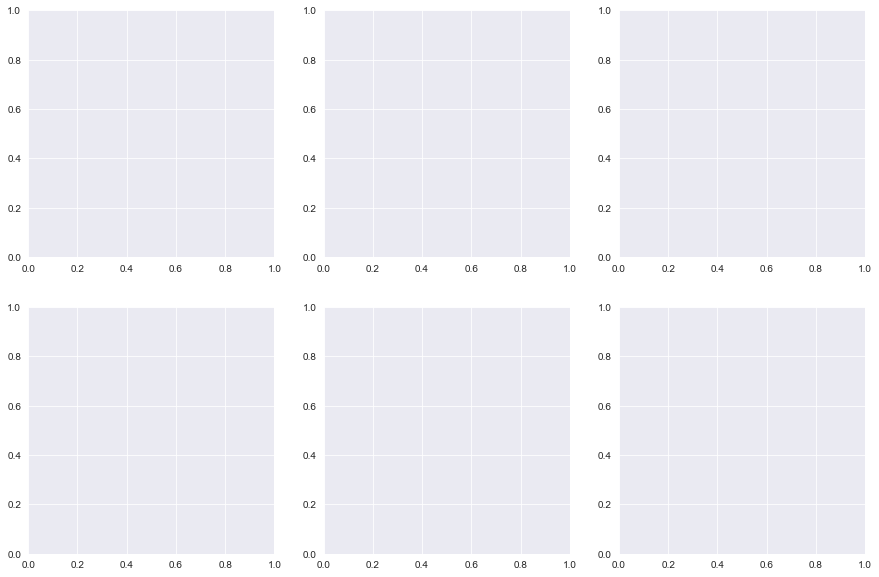

In [17]:
fig, axes = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(15)
types = ["Client","Moyenne", "En Règle", "En Défaut"]

means_global = get_means_features(data_test)
means_repay = get_means_repay(data_test,model)
means_default = get_means_default(data_test,model)

for i,feat in enumerate(list_expl):
    title = list_expl[i][0].split(' <= ')[0]
    value = float(list_expl[i][0].split(' <= ')[1])
    participation = list_expl[i][1]

    if i>5:
        break
    if i<3:
        ax = axes[0,i]
    else :
        ax = axes[1,i-3]

    ax.title.set_text(title)

    value_mean_global = means_global[title]
    value_mean_repay = means_repay[title]
    value_mean_default = means_default[title]

    ax.bar(types,[value, value_mean_global, value_mean_repay, value_mean_default])

plt.show()








In [166]:
json.loads(requests.get("http://127.0.0.1:8000/get_means").text)[1]


KeyError: 0

In [157]:
type

type

In [148]:
requests.get("http://127.0.0.1:8000/get_means")

<Response [200]>

In [113]:
list_expl[0][1]

-0.08259864379481052

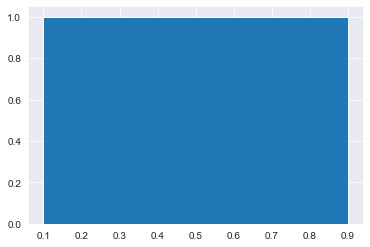

In [121]:
plt.bar(0.5,1)
plt.show()

In [167]:
data_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100001,0.0,0.0,1.0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,100005,0.0,0.0,1.0,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100013,0.0,1.0,1.0,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100028,0.0,0.0,1.0,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,100038,0.0,1.0,0.0,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0.0,0.0,1.0,0.000000,0.000819,0.091775,0.061846,0.057239,0.024260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48740,456222,0.0,0.0,0.0,0.105263,0.001127,0.144173,0.118147,0.113356,0.491595,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48741,456223,0.0,1.0,1.0,0.052632,0.001512,0.067416,0.123201,0.068462,0.361433,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
48742,456224,0.0,0.0,0.0,0.000000,0.001704,0.101124,0.091699,0.102132,0.257000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
